Ham or Spam
===========

A projekt  célja egy olyan modell megalkotása, ami a szövegről (például egy emailről) meg tudja állapítani, hogy az spam -e.

Ehhez a Naive Bayes Machine Learning algoritmus Multinomiális típusát fogom használni, ami egyszerűen és hatékonyan lehet szövegeket feldolgozni.

Importálom a külső függőségeket.

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Az adatok beolvasása
----------------------

Beolvasom az adathalmazt.

In [104]:
data = pd.read_csv(r'.\spam.csv', encoding='latin-1')
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


Kitörlöm a felesleges oszlopokat és a v1 és v2 oszlopokat átnevezem.

In [105]:
data = data.drop(columns =['Unnamed: 2','Unnamed: 3','Unnamed: 4'])
data = data.rename(columns={"v1": "labels", "v2": "text"})
data.head(n=2)

,labels,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


Oszlopdiagramon megjelenítem a hamek és spamek eloszlását.

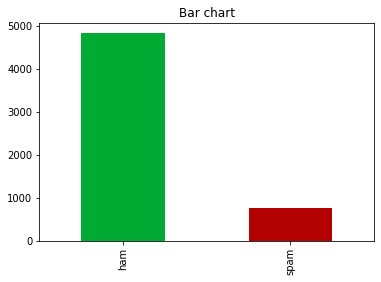

In [106]:
labels_counts=pd.value_counts(data["labels"], sort= True)
labels_counts.plot.bar(color= ["#0A3", "#b30000"])
plt.title('Bar chart')
plt.show()

Most kördiagromon ábrázolom a hamek és spamek eloszlását százalékosan.

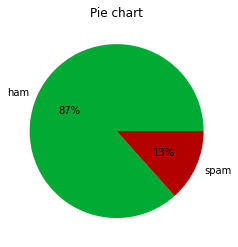

In [107]:
labels_counts.plot.pie(autopct='%1.0f%%', colors = ["#0A3", "#b30000"])
plt.title('Pie chart')
plt.ylabel('')
plt.show()

Az adatok megtisztítása
---------------------
Megvizsgálom a leggyakrabban használt szavakat.

Első lépésben kiválogatom a leggyakrabban használt szavakat DataFramekbe, külön a hamekre és a spamekre.

In [108]:
# true, ahol a label==ham, false, ahol spam
hams_bool = data['labels']=='ham'
# csak a ham-eket tartalmazó sorok
only_hams = data[hams_bool]
#a hamekhez tartozó szövegek
ham_texts = only_hams["text"]

#az összes szó egy stringben
all_ham_text = " ".join(ham_texts)
#az összes szó egy listában, whitespacek mentén elvágva
all_words_list = all_ham_text.split()
#top 20 szó az előfordulásukkal, tuple-ben ('szo', darabszam)
top_words_in_hams = Counter(all_words_list).most_common(20)
top_words_in_hams_dataframe = pd.DataFrame.from_dict(top_words_in_hams)
top_words_in_hams_dataframe = top_words_in_hams_dataframe.rename(columns={0: "words in ham", 1 : "count"})

# Ugyanezt a megcsinálom a spamre, is de már nem mentem ki külön változókba.
top_words_in_spam = Counter(" ".join(data[data['labels']=='spam']["text"]).split()).most_common(20)
top_words_in_spam_dataframe = pd.DataFrame.from_dict(top_words_in_spam)
top_words_in_spam_dataframe = top_words_in_spam_dataframe.rename(columns={0: "words in spam", 1 : "count_"})


A következő lépésben megjelenítem a 20 leggyakoribb szót oszlopdiagramon az üzenetekből osztályonként.

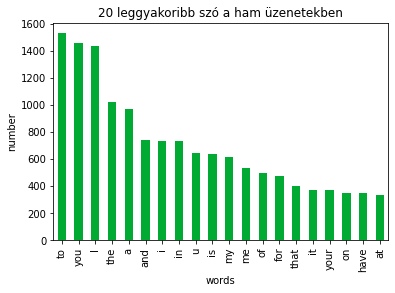

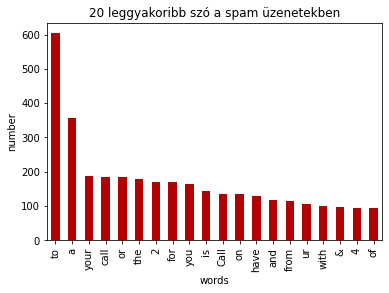

In [109]:
top_words_in_hams_dataframe.plot.bar(legend = False, color = "#0A3")
# len(top_words_in_hams_dataframe["words in ham"]) visszaadja a "words in ham" lista hosszát, majd az np.arange egy egyenletesen elosztott listát ad vissz a 1-20 intervallumon belül
y_pos = np.arange(len(top_words_in_hams_dataframe["words in ham"]))
# a matplotlib.pyplot xticks függvénye pedig az x tengelyen elhelyezi a 20 leggyakoribb szót
plt.xticks(y_pos, top_words_in_hams_dataframe["words in ham"])
plt.title('20 leggyakoribb szó a ham üzenetekben')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

top_words_in_spam_dataframe.plot.bar(legend = False, color = '#b30000')
y_pos = np.arange(len(top_words_in_spam_dataframe["words in spam"]))
plt.xticks(y_pos, top_words_in_spam_dataframe["words in spam"])
plt.title('20 leggyakoribb szó a spam üzenetekben')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

Ez alapján láthatjuk, hogy a gyakran előforduló szavak többsége mindkét osztályban olyan szó, mint „to”, „a”, „the” stb.
Ezek úgynevezett stop wordok, amelyek modell teljesítményét negatívan befolyásolnák, ezért ezeket ki kell szűrni.

Ezt a beépített `CountVectorizer` osztállyal meg lehet oldani, ami kiszűri az angol stop wordoket, és a maradék szavakat mátrixba rendezi.
A mátrix annyi soros, ahány adatunk van, és annyi oszlopos, ahány szavunk van a szövegben.
A mátrix egy eleme 1, ha az adott sorban lévő szövegben szerepel az oszlopban lévő szó, egyébként 0.

Ez a mátrix reprezentálja a modell tulajdonságait (featureit).

In [110]:
word_counter = feature_extraction.text.CountVectorizer(stop_words = 'english')
word_matrix = word_counter.fit_transform(data["text"])
np.shape(word_matrix)

(5572, 8404)

Klasszifikációs modell megalkotása
----------------------------------

Először átkódoljuk a labels oszlop értékeit, azaz a hamet és a spamet számokra (0 és 1), hogy az algoritmus számára használható legyen.

In [111]:
labels_encoded = preprocessing.LabelEncoder().fit_transform(data["labels"])
data["labels"] = labels_encoded
labels_encoded

array([0, 0, 1, ..., 0, 0, 0])

A modell tanításához szétválasztom az adatokat teszt és tanító adathalmazra.
Ebben az esetben a teszt adathalmaz mérete 30% lesz.
A 42-es számmal megadjuk, hogy mindig ugyanazon adatok mentén szelektálja szét az adathalmazt.

In [112]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(word_matrix, data['labels'], test_size=0.3, random_state=42)
print("Training data size: ", np.shape(X_train))
print("Teszt adatok mérete:", np.shape(X_test))

Training data size:  (3900, 8404)
Teszt adatok mérete: (1672, 8404)


Ennek a modellnek egy alpha paramétert kell megadni a nulla frekvencia kiküszöbölésére. Ha véletlenszerűen választanám ki, akkor nem lenne optimális a modell teljesítménye.
Ezért megvizsgálom, hogy melyik a legjobb alpha a modell számára.

Ehhez definiálunk egy listát, amiben az alphák 1/100000 és 20 között 0.11-es mértékkel nőnek (181 db) és minden egyes alphára betanítunk egy modellt és kiértékeljük azt.

In [113]:
alpha_list = np.arange(1/100000, 20, 0.11)
mean_accuracy_score_list = np.zeros(len(alpha_list))
recall_score_list = np.zeros(len(alpha_list))
precision_score_list= np.zeros(len(alpha_list))
index = 0
for alpha in alpha_list:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    mean_accuracy_score_list[index]= bayes.score(X_test, y_test)
    recall_score_list[index] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_score_list[index] = metrics.precision_score(y_test, bayes.predict(X_test))
    index = index + 1

Kiveszem az eredmények közül a legnagyobb Test Precisionhöz tartozó sort.

In [114]:
matrix = np.matrix(np.c_[alpha_list, mean_accuracy_score_list, recall_score_list, precision_score_list])
models = pd.DataFrame(data = matrix, columns = ['alpha', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=20)
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             16.390010
Test Accuracy      0.968301
Test Recall        0.757991
Test Precision     1.000000
Name: 149, dtype: float64

Azt látom, hogy van olyan modell aminek a Test Precisionja 1.0.
Ezért megvizsgálom, hogy van -e több olyan modell, ahol a Test Precision tartozó érték 1.0.

In [115]:
models[models['Test Precision']==1].head(5)

,alpha,Test Accuracy,Test Recall,Test Precision
149,16.39001,0.968301,0.757991,1.0
150,16.50001,0.968301,0.757991,1.0
151,16.61001,0.968301,0.757991,1.0
152,16.72001,0.968301,0.757991,1.0
153,16.83001,0.967105,0.748858,1.0


Mivel több ilyen modell is van, ezért megkeressük azt a modell, ahol a Test Precision == 1.0 és a Test Accuracy a legmagasabb.

In [116]:
best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()
models.iloc[best_index, :]

alpha             16.390010
Test Accuracy      0.968301
Test Recall        0.757991
Test Precision     1.000000
Name: 149, dtype: float64

Megvan a legjobb alphánk: 16.390010.
Újra tanítjuk a modellt ez alapján.

In [117]:
bayes = naive_bayes.MultinomialNB(alpha=alpha_list[best_index])
bayes.fit(X_train, y_train)
predictions = bayes.predict(X_test)

Létrehozzunk a konfúziós mátrixot, amiből megállapítható, hogy a cél amit az elején kitűztünk, sikeres volt. Egyetlen ham sem került a spamek közé, azonban 53 spam került a hamek közé.

In [118]:
m_confusion_test = metrics.confusion_matrix(y_test, predictions)
confusion_matrix = pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0 (ham)', 'Predicted 1 (spam)'],
            index = ['Actual 0 (ham)', 'Actual 1 (spam)'])
confusion_matrix

,Predicted 0 (ham),Predicted 1 (spam)
Actual 0 (ham),1453,0
Actual 1 (spam),53,166
